# Demonstration: Maximising Persistence

We demonstrate how we can find a spectral wavelet, parametrised by a basis of chebyshev polynomials, such that the total persistence of a graph's filtration is maximised. 

In [1]:
import numpy as np
import networkx as nx

import torch
import torch.optim as optim
import torch.nn as nn

import numpy as np
from scipy.linalg import eigh

import pickle

from models import models
from models import utils
import numpy.polynomial.chebyshev as cheby

import matplotlib.pyplot as plt

## Choosing a Model

We consider a wavelet spanned by a degree 6 chebyshev polynomial, with coefficients normalised to 1. We truncate the barcode to the 25 most persistent intervals as a computational necessity

In [2]:
cheby_degree = 6
max_intervals = 25

## Loading the data


In [3]:
dataset_name = 'MUTAG'

graph_list = pickle.load(open('data_example/' + dataset_name + '/networkx_graphs.pkl', 'rb'))

print('The ' + dataset_name + ' dataset has ', len(graph_list), ' graphs.')

The MUTAG dataset has  188  graphs.


## Preprocess the data

The ChebyshevWavelets pytorch module takes in a list of dictionaries, each dictionary representing the necessary data to compute spectral wavelets.

The dictionary contains the following fields:
- 'chebyshev': an intermediary matrix (num vertices) x (chebyshev degree) for computations; the vertex values of the filtration are given by the product of this matrix with the vector of chebyshev coefficients
- 'simplex_tree': the Gudhi representation of a simplicial complex

In [4]:
data = []
for i in range(len(graph_list)):
    
    G = graph_list[i]
    datum = dict()
    L = nx.normalized_laplacian_matrix(G)
    w, v = eigh(L.todense()) #computes eigenvalues w and eigenvectors
    vandermonde = cheby.chebvander(w.flatten()-1, cheby_degree)
    datum['chebyshev'] = torch.from_numpy(np.matmul(v**2, vandermonde[:, 1:])).float()

    hks = np.matmul(v**2,  np.exp(-0.1*w)).flatten() #random initial filtration for the simplex_tree
    st = utils.simplex_tree_constructor([list(e) for e in G.edges()])
    datum['simplex_tree'] = utils.filtration_update(st, hks)
    data.append(datum)
print('Finished initial processing')
del graph_list


Finished initial processing


## Experiment Design

### Tenfolding

We find a set of chebyshev coefficients that maximise the average $L^2$-persistence of the graph barcodes across the dataset

We perform a ten-fold cross validation. In a ten-fold, we randomly partition the dataset into 10 portions. We perform the maximisation across 9 portions and then validate the learnt parameters on the remaining portion. We cycle through the ten portions so that each portion is the validation set once.

Normally in machine learning practices, we conduct 10 ten-folds and average across all 100 validation measures, but in the interest of time we only perform one ten-fold in this demo.

In [5]:
data_len = len(data)
test_size = data_len // 10
train_size = data_len - test_size

### Optimisation using PyTorch tools
We specify the batch size and the number of epochs. We use stochastic gradient descent.

In [6]:
### training parameters #####
batch_size = 20
train_batches = np.ceil((data_len-test_size)/batch_size).astype(int)
max_epoch = 25

print('num points = ', data_len, ' number of batches = ', train_batches, ' batch size = ', batch_size, ' test size ', test_size)

num points =  188  number of batches =  9  batch size =  20  test size  18


In [11]:
####### torch random seeds #######
shuffidx = list(range(data_len)) # data indexer

torch.manual_seed(99)
rng_state= torch.get_rng_state() #seed init to ensure same initial conditions for each training

p_tracker = []
tt_loss = []
tn_loss = []

for fold in range(10):
    print ('> fold ', fold)

    param_tracker = []
    test_loss = []
    train_loss = []

    test_bottom = fold * test_size
    test_top = (1+fold) * test_size
    test_indices = shuffidx[test_bottom : test_top]
    train_indices = shuffidx[0:test_bottom] + shuffidx[test_top :]

    torch.set_rng_state(rng_state) #fix init state
    barcodes = models.ChebyshevWavelets(cheby_degree = cheby_degree, max_intervals = max_intervals)
    param_tracker.append(list(barcodes.cheby_params.detach().flatten().numpy()))

    optimizer = optim.SGD(barcodes.parameters(), lr=1e-3, weight_decay = 0.0)

    for epoch in range(max_epoch):
        
        barcodes.train()
        np.random.shuffle(train_indices)
        for b in range(train_batches):

            train_indices_batch = train_indices[b*batch_size : (b+1)*batch_size ]
            optimizer.zero_grad()
            births, deaths = barcodes([data[i] for i in train_indices])
            loss = -torch.sum((deaths - births)**2)/train_size
            loss.backward()
            
            optimizer.step()

        barcodes.eval()
        param_tracker.append(list(barcodes.cheby_params.detach().flatten().numpy()))


        barcodes.eval()
        b,d = barcodes([data[i] for i in train_indices])
        tnl = torch.sum((d- b)**2)/train_size
        b,d  = barcodes([data[i] for i in test_indices])
        ttl = torch.sum((d- b)**2)/test_size
        test_loss.append(ttl.detach().numpy())
        train_loss.append(tnl.detach().numpy())
        
        if epoch % 5 == 0:
            print(epoch, param_tracker[-1])
            print('train: ', train_loss[-1])
            print('test: ',test_loss[-1])

    p_tracker.append(param_tracker)
    tt_loss.append(test_loss)
    tn_loss.append(train_loss)

> fold  0
0 [0.19036105, -0.4159127, -0.23757598, -0.18465443, 0.23188566, -0.21285376]
train:  1.2047864
test:  1.0679982
5 [0.11450073, -0.5557092, -0.14290018, 0.053557545, 0.14105015, -0.18975982]
train:  3.4869852
test:  3.1525507
10 [0.042884927, -0.56621563, -0.053521603, 0.24313955, 0.05292596, -0.12380713]
train:  4.9112477
test:  4.481274
15 [0.01358191, -0.544202, -0.016950613, 0.31491297, 0.015912464, -0.082236245]
train:  5.1722
test:  4.7312784
20 [0.0041911765, -0.53321284, -0.0052307085, 0.33848995, 0.003809475, -0.062432274]
train:  5.2066092
test:  4.76382
> fold  1
0 [0.19064935, -0.41512036, -0.23793578, -0.1854364, 0.23228288, -0.21259479]
train:  1.1632358
test:  1.3824201
5 [0.11697026, -0.55390686, -0.14598213, 0.04852177, 0.1444319, -0.1897299]
train:  3.3618822
test:  3.7908945
10 [0.04497425, -0.566393, -0.05612911, 0.24099313, 0.055955138, -0.123679295]
train:  4.8138804
test:  5.2415457
15 [0.01452461, -0.5438004, -0.018127114, 0.3156221, 0.017540457, -0.08

In [12]:
tt_loss = np.array(tt_loss)
tn_loss = np.array(tn_loss)

In [13]:
mean_test = np.mean(tt_loss, axis=0)
std_test = np.std(tt_loss, axis=0)

mean_train =np.mean(tn_loss, axis=0)
std_train = np.std(tn_loss, axis=0)


We see that the optimisation has converged to a local optimum and the test 

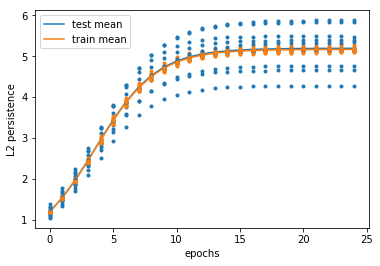

In [20]:
plt.plot(mean_test, label = 'test mean')
plt.plot(mean_train, label = 'train mean')
plt.xlabel('epochs')
plt.ylabel('L2 persistence')
for i in range(10):
    plt.plot(tt_loss[i], '.', color = 'tab:blue')
    plt.plot(tn_loss[i], '.', color = 'tab:orange')
plt.legend()